# Transfer Learning

Importing libraries

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
project_path = "/content/gdrive/MyDrive/ColabData"

import sys
sys.path.append('/content/gdrive/MyDrive/ColabData')

import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, Conv1D, MaxPooling1D, GlobalMaxPool1D, UpSampling1D, Reshape
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Mounted at /content/gdrive


Loading a pre-processed version of the [PAMAP2](https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring) dataset that contains data of different physical activities (such as walking, cycling, etc.), performed by 9 subjects wearing 3 inertial measurement units.

This pre-processed version segmented the original data into windows of 2 seconds.

In [ ]:
with open(f"{project_path}/pamap2_2_seconds_0_overlap.txt", "rb") as f:
  pamap2 = pickle.load(f)

samples = np.concatenate((pamap2["accelerometer_samples"], pamap2["gyroscope_samples"]), axis=2)
labels, users = pamap2["labels"], pamap2["subjects"]

del pamap2

Overall, we have 9628 segmentation windows with shape (200, 6): 200 raw measurements for each axis of a triaxial inertial sensor (accelerometer and gyroscope).

In [ ]:
print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

Samples: (9628, 200, 6)
Labels: (9628,)
Users: (9628,)


These are the classes IDs of the dataset

In [ ]:
classes = list(np.unique(labels))
print("Activities: ", classes)

Activities:  [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]


Based on the dataset readme, we can map these IDs to strings.

In [ ]:
activities_map = {
     0: "other",
     1: "lying",
     2: "sitting",
     3: "standing",
     4: "walking",
     5: "running",
     6: "cycling",
     7: "nordic walking",
     9: "watching TV",
    10: "computer work",
    11: "car driving",
    12: "ascending stairs",
    13: "descending stairs",
    16: "vacuum cleaning",
    17: "ironing",
    18: "folding laundry",
    19: "house cleaning",
    20: "playing soccer",
    24: "rope jumping"
}

labels = np.array([activities_map[lab] for lab in list(labels)])
print("Activities:", list(np.unique(labels)))

Activities: ['ascending stairs', 'cycling', 'descending stairs', 'ironing', 'lying', 'nordic walking', 'rope jumping', 'running', 'sitting', 'standing', 'vacuum cleaning', 'walking']


Checking the labels distribution.

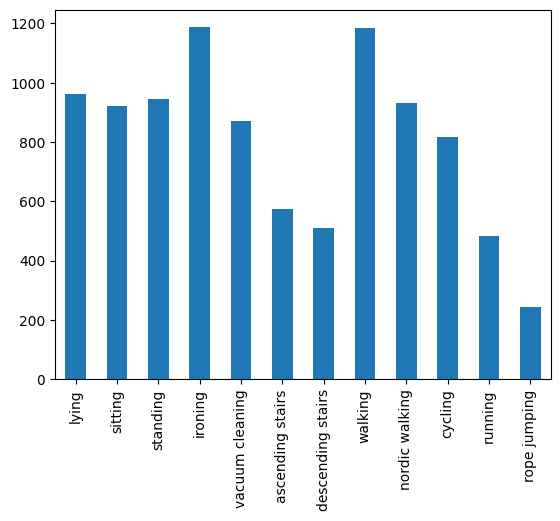

In [ ]:
import pandas as pd

pd.Series(labels).value_counts(sort=False).plot(kind='bar')
plt.show()

Let's keep only labels with high frequency.

In [ ]:
to_keep = np.where((labels != "rope jumping") & (labels != "running") & (labels != "descending stairs") & (labels != "ascending stairs"))[0]

samples, labels, users = samples[to_keep], labels[to_keep], users[to_keep]

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

classes = sorted(list(set(labels)))
print("Classes:", classes)

Samples: (7816, 200, 6)
Labels: (7816,)
Users: (7816,)
Classes: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']


One-hot encoding labels to train our models.

In [ ]:
enc = OneHotEncoder()
ohe_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

print(f"Original list of labels: {classes}")

print(f'Example of original label: {labels[3000]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels[3000]}")

Original list of labels: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Example of original label: standing
...and the corresponding one-hot encoded version: [0. 0. 0. 0. 0. 1. 0. 0.]


Utility function to plot confusion matrices.

In [10]:
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

<br>

We simulate a scenario in which we want to recognize the activities of a new subject, but we don't have many labeled data.

Fortunately, we had already provided our framework to other subjects, and we have much more labeled data of them. The only problem is that we never collected data about the activity "standing", but now we want to recognize it for the new subject.

What can we do?

We split the dataset into:
* **Pre-train set**: labeled data from the subjects that already use our framework, without the Standing activity
* **Fine-tuning set**: low amount of labeled data from the new subject, including the Standing activity
* **Test set**: test data from the new subject, useful to validate our transfer learning solution

Then we will compare two models:
1. **Baseline**: a method trained only relying on the low amount of labeled data from the new subject (i.e., the fine-tuning set)
2. **Transfer Learning method**: a method pre-trained on the pre-train set (without the Standing activity), and fine-tuned on the fine-tuning set (with the Standing activity). This method transfers its knowledge about the previous subjects to the new subject

In [ ]:
pre_train = np.where((users != 101) & (labels != "standing"))[0]
fine_tuning = np.where((users == 101))[0]

# from the data of the new subject, we use 5% for fine-tuning and 95% for test
fine_tuning, test, _, _ = train_test_split(fine_tuning, labels[fine_tuning], test_size=0.95, random_state=0)

print(f"Pre-train size: {len(pre_train)} ({len(pre_train)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(pre_train)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[pre_train])))}")
print(f"Fine-tuning size: {len(fine_tuning)} ({len(fine_tuning)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(fine_tuning)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[fine_tuning])))}")
print(f"Test size: {len(test)} ({len(test)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%). Activities: {sorted(list(set(labels[test])))}")

Pre-train size: 6060 (86.84%) -> 202.00 minutes of data. Activities: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'vacuum cleaning', 'walking']
Fine-tuning size: 45 (0.64%) -> 1.50 minutes of data. Activities: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Test size: 873 (12.51%). Activities: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']


### Baseline

In [ ]:
def baseline(num_classes=len(classes)):
  input = Input((200, 6), name="input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv1")(input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d')(x1)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x1)

  model = Model(inputs=input, outputs=classification_out, name="baseline")

  return model

In [ ]:
model = baseline()
print(model.summary())

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling1d (Globa  (None, 96)               0  


Creating the model...

Training...
Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.0747 - accuracy: 0.2250 - val_loss: 2.3657 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 166ms/step - loss: 1.6919 - accuracy: 0.3000 - val_loss: 2.0421 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 188ms/step - loss: 1.4720 - accuracy: 0.4250 - val_loss: 1.7348 - val_accuracy: 0.4000
Epoch 4/200
1/1 [==============================] - 0s 162ms/step - loss: 1.2893 - accuracy: 0.6000 - val_loss: 1.4717 - val_accuracy: 0.4000
Epoch 5/200
1/1 [==============================] - 0s 175ms/step - loss: 1.1442 - accuracy: 0.6750 - val_loss: 1.2516 - val_accuracy: 0.8000
Epoch 6/200
1/1 [==============================] - 0s 151ms/step - loss: 1.0160 - accuracy: 0.8000 - val_loss: 1.0661 - val_accuracy: 0.8000
Epoch 7/200
1/1 [==============================] - 0s 162ms/step - loss: 0.8932 - accuracy: 0.8000 - val_loss: 0.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

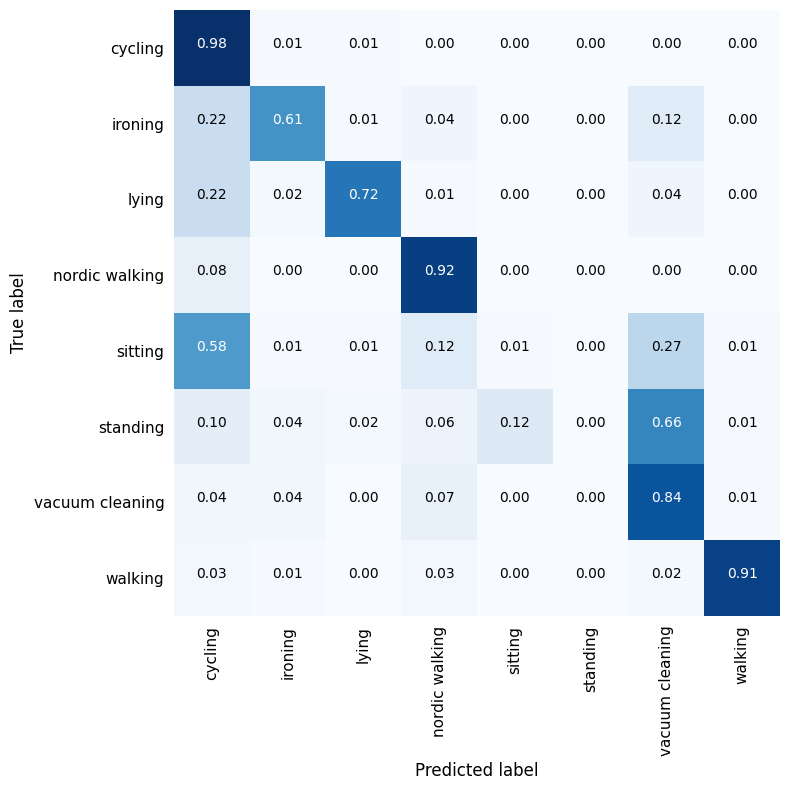

In [ ]:
# early stopping: if for 5 consecutive epochs the loss on the validation set does not improve, we stop the training process and restore the weights of the best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 200
batch_size = 128


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("\nCreating the model...")
model = baseline()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nTraining...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

Note that the baseline is not able to recognize *standing* because in the fine-tuning set there are not enough labeled data to learn how to distinguish *standing* from the other activities (especially *vacuum cleaning*).


### Transfer Learning method

This will be our transfer learning pipeline:

1. **Pre-training**: pre-train a classifier on the pre-train set without the Standing activity

2. **Fine-tuning**: take the layers of the pre-trained model in charge of extracting features, add new trainable layers on top of them, and fine tune the model on the fine-tuning set. The new layers will learn how to turn the old features into predictions for the new subject (including the Standing activity). The goal is to adapt the model to the specific characteristics of the target problem while retaining the general knowledge learned during pretraining. This step can be implemented in two different ways: by freezing or unfreezing the feature extraction layers. If we unfreeze the layers, it is typically better to user a very low learning rate to avoid changing unsafely the weights of the feature extraction layers

<br>

Pre-training

In [ ]:
enc = OneHotEncoder()
ohe_labels_pre_train = enc.fit_transform(labels[pre_train].reshape(-1,1)).toarray()

classes_pre_train = sorted(list(set(labels[pre_train])))
print(f"Original list of labels: {classes_pre_train}")

print(f'Example of original label: {labels[pre_train][0]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels_pre_train[0]}")

Original list of labels: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'vacuum cleaning', 'walking']
Example of original label: lying
...and the corresponding one-hot encoded version: [0. 0. 1. 0. 0. 0. 0.]


In [ ]:
def pre_train_classifier(num_classes=len(classes_pre_train)):
  input = Input((200, 6), name="input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv1")(input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d')(x1)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x1)

  model = Model(inputs=input, outputs=classification_out, name="pre_train_classifier")

  return model

In [ ]:
model = pre_train_classifier()
print(model.summary())

Model: "pre_train_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling1d (Globa  (None, 96)      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 200
batch_size = 128

print("Creating the model...")
pre_trained_model = pre_train_classifier()
pre_trained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


# get validation data
samples_pre_train, samples_val, ohe_labels_pre_train, ohe_labels_val = train_test_split(samples[pre_train], ohe_labels_pre_train, test_size=0.1)


print("\nTraining...")
history = pre_trained_model.fit(x=samples_pre_train,
                  y=ohe_labels_pre_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping],
                  verbose=1)

Creating the model...

Training...
Epoch 1/200
43/43 [==============================] - 20s 437ms/step - loss: 0.8402 - accuracy: 0.7219 - val_loss: 0.5225 - val_accuracy: 0.8333
Epoch 2/200
43/43 [==============================] - 17s 402ms/step - loss: 0.4582 - accuracy: 0.8566 - val_loss: 0.4156 - val_accuracy: 0.8614
Epoch 3/200
43/43 [==============================] - 22s 517ms/step - loss: 0.3787 - accuracy: 0.8817 - val_loss: 0.3808 - val_accuracy: 0.8845
Epoch 4/200
43/43 [==============================] - 24s 546ms/step - loss: 0.3573 - accuracy: 0.8872 - val_loss: 0.3339 - val_accuracy: 0.8927
Epoch 5/200
43/43 [==============================] - 22s 511ms/step - loss: 0.3084 - accuracy: 0.9025 - val_loss: 0.3813 - val_accuracy: 0.8795
Epoch 6/200
43/43 [==============================] - 19s 426ms/step - loss: 0.2878 - accuracy: 0.9058 - val_loss: 0.3344 - val_accuracy: 0.8894
Epoch 7/200
43/43 [==============================] - 17s 402ms/step - loss: 0.2619 - accuracy: 0.9131

We have pre-trained our model, now we can perform fine-tuning.

In [ ]:
def fine_tune_classifier(pre_trained_model, freeze_feature_extractors=True, num_classes=len(classes)):
  feature_extractor = pre_trained_model.get_layer("conv3").output

  x = GlobalMaxPool1D(name='global_max_pooling')(feature_extractor)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = Model(inputs=pre_trained_model.input, outputs=classification_out, name="fine_tuning_classifier")

  if freeze_feature_extractors:
    for layer in model.layers[:-2]: layer.trainable = False
  else:
    for layer in model.layers[:-2]: layer.trainable = True

  return model

Note how the number of trainable params changes based on the freezing/unfreezing option! Also note that now we have 8 output neurons instead of 7, because we added the activity *standing*.

In [ ]:
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=True)
print(model.summary())

print("\nTrainable layers:")
for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "fine_tuning_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling (GlobalM  (None, 96)    

In [ ]:
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=False)
print(model.summary())

print("\nTrainable layers:")
for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "fine_tuning_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling (GlobalM  (None, 96)    

Fine-tuning while freezing the feature extraction layers.


Creating the new model to fine-tune...

Fine-tuning...

Predicting...
28/28 [==============================] - 1s 28ms/step

Classification Report:
                 precision    recall  f1-score   support

        cycling     0.8829    0.8991    0.8909       109
        ironing     0.7615    0.7411    0.7511       112
          lying     0.8138    0.9077    0.8582       130
 nordic walking     0.6822    0.8022    0.7374        91
        sitting     0.6327    0.5487    0.5877       113
       standing     0.6180    0.5238    0.5670       105
vacuum cleaning     0.7921    0.7339    0.7619       109
        walking     0.8053    0.8750    0.8387       104

       accuracy                         0.7560       873
      macro avg     0.7486    0.7539    0.7491       873
   weighted avg     0.7513    0.7560    0.7516       873


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

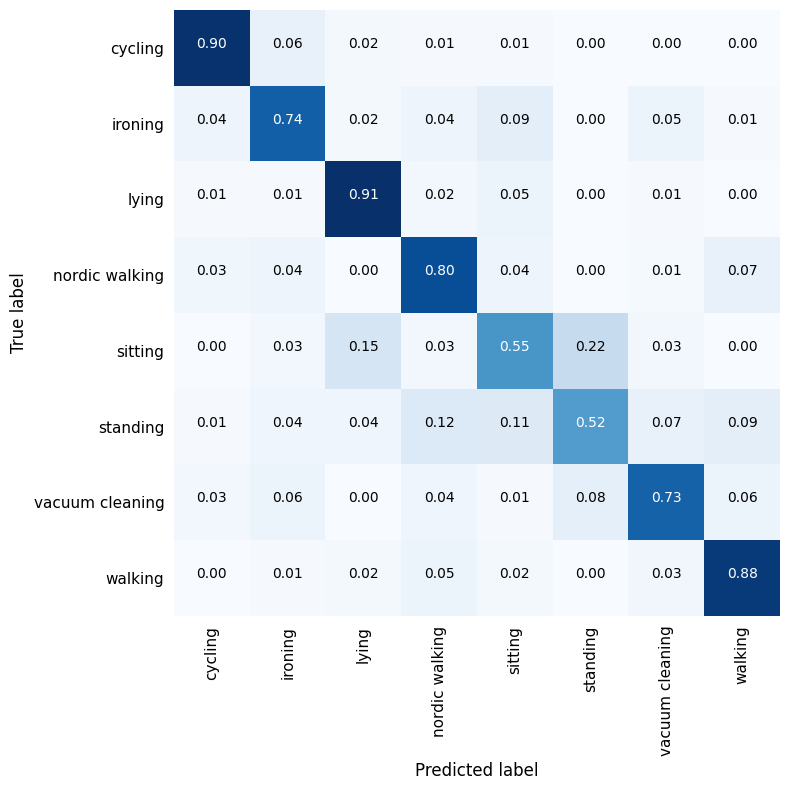

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 2000
batch_size = 128


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)

print("\nCreating the new model to fine-tune...")
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nFine-tuning...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping],
                  verbose=0)


print("\nPredicting...")
y_preds = model.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

Fine-tuning without freezing the feature extraction layers


Creating the new model to fine-tune...

Fine-tuning...

Predicting...
28/28 [==============================] - 1s 21ms/step

Classification Report:
                 precision    recall  f1-score   support

        cycling     0.8268    0.9633    0.8898       109
        ironing     0.9286    0.5804    0.7143       112
          lying     0.8163    0.9231    0.8664       130
 nordic walking     0.7434    0.9231    0.8235        91
        sitting     0.5545    0.4956    0.5234       113
       standing     0.4615    0.5714    0.5106       105
vacuum cleaning     0.5870    0.4954    0.5373       109
        walking     1.0000    0.8942    0.9442       104

       accuracy                         0.7297       873
      macro avg     0.7397    0.7308    0.7262       873
   weighted avg     0.7411    0.7297    0.7263       873


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

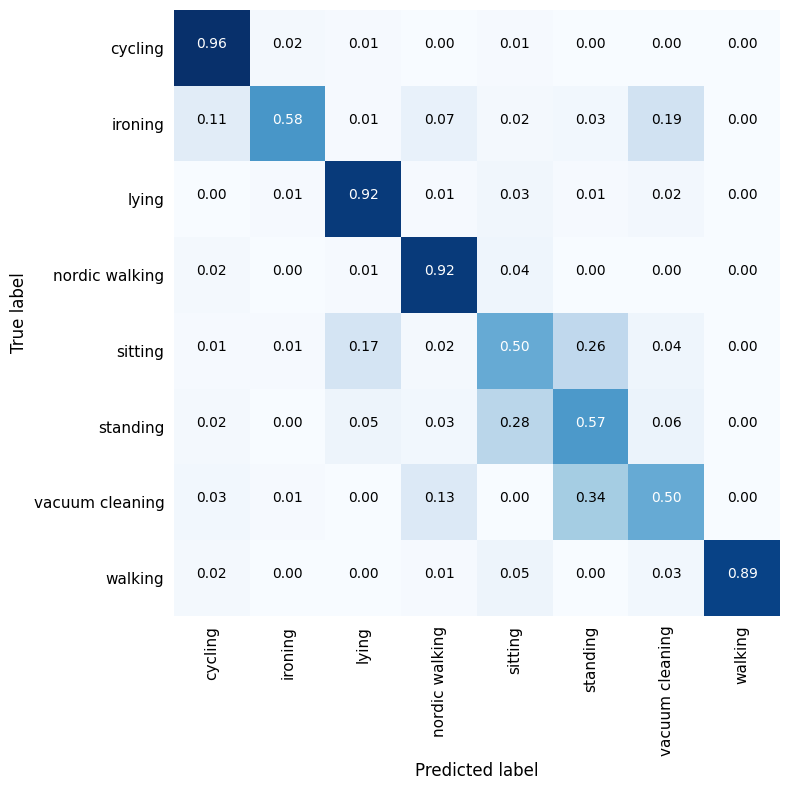

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 2000
batch_size = 128


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("\nCreating the new model to fine-tune...")
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=False)
model.compile(optimizer=keras.optimizers.Adam(0.0001),   # lower learning rate to allow better adapting the weights of the feature extraction layers
              loss='categorical_crossentropy',
              metrics=["accuracy"])


print("\nFine-tuning...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping],
                  verbose=0)


print("\nPredicting...")
y_preds = model.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

With transfer learning we have a huge boost in the recognition rates, even for *standing* that is not in the data used to pre-train the model fine-tuned for transfer learning.

<br>

|                       | Baseline |   | Transfer Learning <br>(freezing) |   | Transfer Learning <br>(no freezing) |
|-----------------------|:--------:|---|:--------------------------------:|---|:-------------------------------------:|
| Accuracy              |    0.6186     |   |                 **0.7560**                |   |                  0.7297                  |
| Macro avg F1-score    |     0.5553    |   |                 **0.7491**                |   |                  0.7262                  |
| Weighted avg F1-score |     0.5550    |   |                 **0.7516**                |   |                  0.7263                  |

<hr>

# Self-Supervised Learning

We'll see a scenario similar to the one we've seen for Transfer Learning.

We split the dataset into:

* **Pre-train set**: unlabeled data from different subjects

* **Fine-tuning set**: low amount of labeled data from the new subject,

* **Test set**: test data from the new subject, useful to validate our transfer learning solution


Then, we will compare two approaches:
* **Baseline**: a model trained only on the available labeled data (i.e., the fine-tuning set)

* **Sim-CLR-based Self-supervised method**: a model pre-trained on the unlabeled data (i.e., the pre-train set) thanks to the Sim-CLR framework, and then fine-tuned on the small fine-tuning set.

<br>

To ease the learning process, here we just consider accelerometer data.

In [2]:
f = open(f"{project_path}/pamap2_2_seconds_0_overlap.txt", "rb")
pamap2 = pickle.load(f)

samples = pamap2["accelerometer_samples"]
labels, users = pamap2["labels"], pamap2["subjects"]

del pamap2

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

Samples: (9628, 200, 3)
Labels: (9628,)
Users: (9628,)


In [5]:
labels = np.array([activities_map[lab] for lab in list(labels)])

to_keep = np.where((labels != "rope jumping") & (labels != "running") & (labels != "descending stairs") & (labels != "ascending stairs"))[0]

samples, labels, users = samples[to_keep], labels[to_keep], users[to_keep]

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

classes = sorted(list(set(labels)))
print("Classes:", classes)

Samples: (7816, 200, 3)
Labels: (7816,)
Users: (7816,)
Classes: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']


In [6]:
enc = OneHotEncoder()
ohe_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

print(f"Original list of labels: {classes}")

print(f'Example of original label: {labels[3000]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels[3000]}")

Original list of labels: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Example of original label: standing
...and the corresponding one-hot encoded version: [0. 0. 0. 0. 0. 1. 0. 0.]


<br>

Splitting into pre-train, fine-tuning, and test sets.

In [12]:
pre_train = np.where((users != 101))[0]
fine_tuning = np.where((users == 101))[0]

# from the data of the new subject, we use 5% for fine-tuning and 95% for test
fine_tuning, test, _, _ = train_test_split(fine_tuning, labels[fine_tuning], test_size=0.95, random_state=0)

print(f"Pre-train size: {len(pre_train)} ({len(pre_train)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(pre_train)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[pre_train])))}")
print(f"Fine-tuning size: {len(fine_tuning)} ({len(fine_tuning)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(fine_tuning)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[fine_tuning])))}")
print(f"Test size: {len(test)} ({len(test)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%). Activities: {sorted(list(set(labels[test])))}")

Pre-train size: 6898 (88.25%) -> 229.93 minutes of data. Activities: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Fine-tuning size: 45 (0.58%) -> 1.50 minutes of data. Activities: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Test size: 873 (11.17%). Activities: ['cycling', 'ironing', 'lying', 'nordic walking', 'sitting', 'standing', 'vacuum cleaning', 'walking']


### Baseline

In [13]:
def baseline(num_classes=len(classes)):
  input = Input((200, 3), name="input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv1")(input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d')(x1)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x1)

  model = Model(inputs=input, outputs=classification_out, name="baseline")

  return model


Creating the model...

Training...
Epoch 1/200
2/2 [==============================] - 2s 775ms/step - loss: 2.0417 - accuracy: 0.1250 - val_loss: 2.0707 - val_accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 0s 35ms/step - loss: 1.5902 - accuracy: 0.2500 - val_loss: 2.0358 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 0s 33ms/step - loss: 1.4250 - accuracy: 0.3500 - val_loss: 1.8205 - val_accuracy: 0.2000
Epoch 4/200
2/2 [==============================] - 0s 35ms/step - loss: 1.2142 - accuracy: 0.6250 - val_loss: 1.5893 - val_accuracy: 0.4000
Epoch 5/200
2/2 [==============================] - 0s 41ms/step - loss: 1.0242 - accuracy: 0.6500 - val_loss: 1.4606 - val_accuracy: 0.4000
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.8893 - accuracy: 0.7500 - val_loss: 1.3755 - val_accuracy: 0.4000
Epoch 7/200
2/2 [==============================] - 0s 32ms/step - loss: 0.7417 - accuracy: 0.8250 - val_loss: 1.360

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

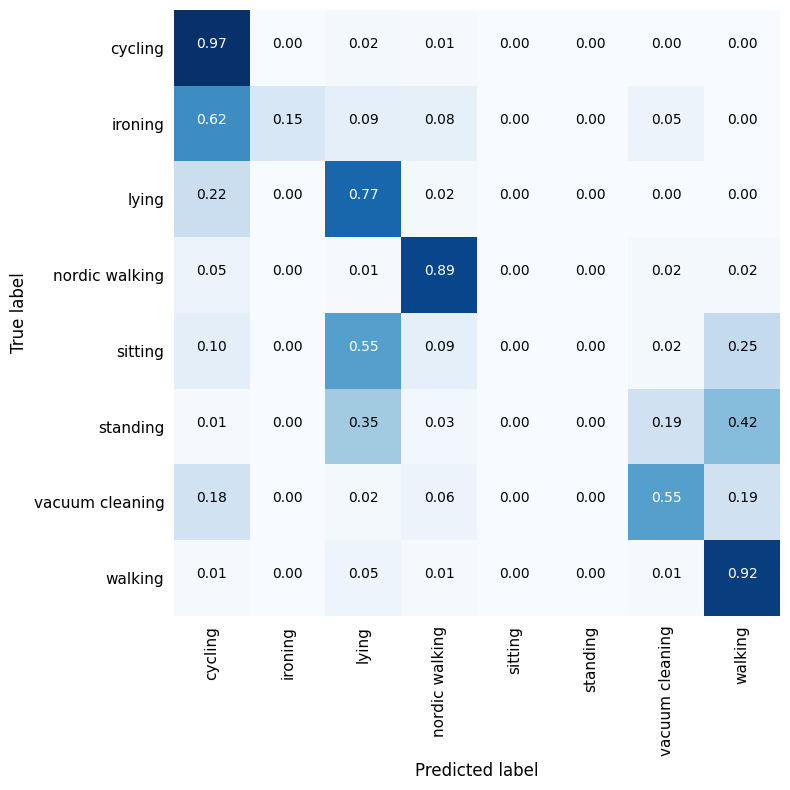

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 200
batch_size = 32


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)
samples_test = samples[test]


print("\nCreating the model...")
model = baseline()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nTraining...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

### Sim-CLR (Self-Supervised Learning)

Part of this section is based on [this paper](https://arxiv.org/abs/2011.11542) and adapted from the corresponding [GitHub repository](https://github.com/iantangc/ContrastiveLearningHAR).

This is how Sim-CLR (that is based on contrastive learning) works.

![](https://github.com/iantangc/ContrastiveLearningHAR/raw/main/img/SimCLR_HAR.png)

Let's create some functions that can be used to transform sensor data.

In [15]:
def axis_angle_to_rotation_matrix_3d(axes, angles):
    """
    Get the rotational matrix corresponding to a rotation of (angle) radian around the axes
    Reference: the Transforms3d package - transforms3d.axangles.axangle2mat
    Formula: http://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle
    """
    axes = axes / np.linalg.norm(axes, ord=2, axis=1, keepdims=True)
    x = axes[:, 0]; y = axes[:, 1]; z = axes[:, 2]
    c = np.cos(angles)
    s = np.sin(angles)
    C = 1 - c

    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC

    m = np.array([
        [ x*xC+c,   xyC-zs,   zxC+ys ],
        [ xyC+zs,   y*yC+c,   yzC-xs ],
        [ zxC-ys,   yzC+xs,   z*zC+c ]])
    matrix_transposed = np.transpose(m, axes=(2,0,1))
    return matrix_transposed


def rotation_transform(X):
    """
    Applying a random 3D rotation
    """
    axes = np.random.uniform(low=-1, high=1, size=(X.shape[0], X.shape[2]))
    angles = np.random.uniform(low=-np.pi, high=np.pi, size=(X.shape[0]))
    matrices = axis_angle_to_rotation_matrix_3d(axes, angles)

    return np.matmul(X, matrices)


def negate_transform(X):
    """
    Inverting the signals
    """
    return X * -1

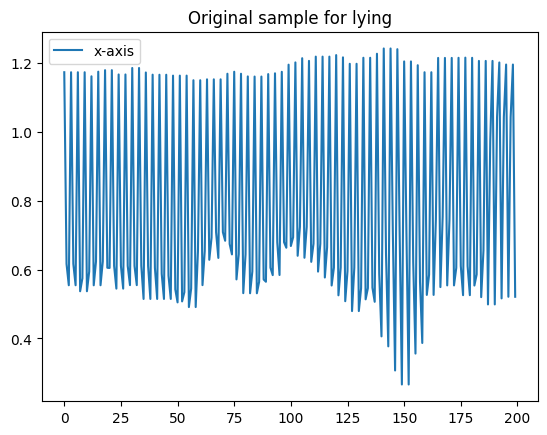

In [16]:
idx = 0
sample_to_plot = samples[idx].reshape((3,200))

plt.plot(list(range(200)), sample_to_plot[0], label="x-axis")
plt.title(f"Original sample for {labels[idx]}")
plt.legend()
plt.show()

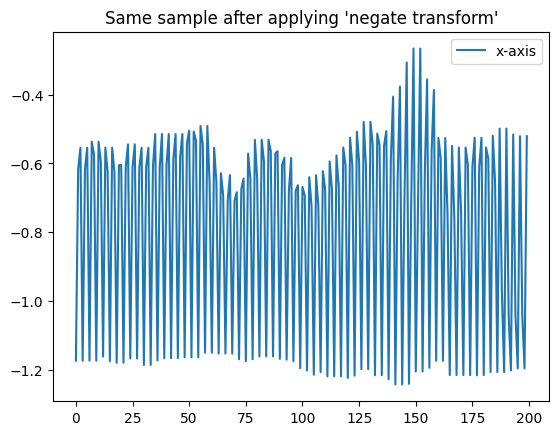

In [17]:
idx = 0
sample_to_plot = negate_transform(samples[idx].reshape((1,200,3)))
sample_to_plot = sample_to_plot.reshape((3,200))

plt.plot(list(range(200)), sample_to_plot[0], label="x-axis")
plt.title("Same sample after applying 'negate transform'")
plt.legend()
plt.show()

<br>

Let's define the Sim-CLR model

In [18]:
# encoder network
def create_base_model(input_shape=(200,3)):
    inputs = tf.keras.Input(shape=input_shape, name='input')

    x = Conv1D(32, 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(inputs)
    x = Dropout(0.1)(x)

    x = Conv1D(64, 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(x)
    x = Dropout(0.1)(x)

    x = Conv1D(96, 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(x)
    x = Dropout(0.1)(x)

    x = GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d')(x)

    return Model(inputs, x, name="base_model")

In [19]:
# projector network
def attach_simclr_head(base_model):
    input = base_model.input
    x = base_model.output

    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    return Model(input, x, name="sim_clr_model")

In [42]:
base_model = create_base_model()
simclr_model = attach_simclr_head(base_model)
print(simclr_model.summary())

Model: "sim_clr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 177, 32)           2336      
                                                                 
 dropout_9 (Dropout)         (None, 177, 32)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 162, 64)           32832     
                                                                 
 dropout_10 (Dropout)        (None, 162, 64)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 155, 96)           49248     
                                                                 
 dropout_11 (Dropout)        (None, 155, 96)         

<br>

This is an adaptation of the train function implemented in the original paper

In [43]:
import math
import random
import copy

def simclr_train_model(model, training_set, optimizer, batch_size, transformation_function, temperature=1.0, epochs=100, verbose=0, early_stopping_patience=0):
    epoch_wise_loss = []

    if early_stopping_patience > 0:
        best_loss = -1
        best_model = None
        epochs_counter = 0

    for epoch in range(epochs):
        step_wise_loss = []

        # Randomly shuffle the dataset
        indices = np.arange(len(training_set))
        np.random.shuffle(indices)
        shuffled_dataset = training_set[indices]

        # Training
        num_batches = math.ceil(len(training_set) / batch_size)

        for i in range(num_batches):
            data_batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]

            # Apply transformation
            transform_1 = transformation_function(data_batch)
            transform_2 = transformation_function(data_batch)

            # Forward propagation
            loss, gradients = get_NT_Xent_loss_gradients(model, transform_1, transform_2, normalize=True, temperature=temperature, weights=1.0)

            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            step_wise_loss.append(loss)

        mean_step_wise_loss = np.mean(step_wise_loss)
        epoch_wise_loss.append(mean_step_wise_loss)

        if verbose > 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, mean_step_wise_loss))

        # implementing early stopping
        if early_stopping_patience > 0:
            if best_loss == -1 or mean_step_wise_loss < best_loss:
                epochs_counter = 0
                best_loss = mean_step_wise_loss
                best_model = copy.deepcopy(model)

            epochs_counter += 1
            if epochs_counter == early_stopping_patience+1:
                break

    if early_stopping_patience > 0:
        return best_model, epoch_wise_loss[:-early_stopping_patience]
    else:
        return model, epoch_wise_loss





def get_NT_Xent_loss_gradients(model, samples_transform_1, samples_transform_2, normalize=True, temperature=1.0, weights=1.0):
    with tf.GradientTape() as tape:
        hidden_features_transform_1 = model(samples_transform_1)
        hidden_features_transform_2 = model(samples_transform_2)
        loss = NT_Xent_loss(hidden_features_transform_1, hidden_features_transform_2, normalize=normalize, temperature=temperature, weights=weights)

    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients




# this Python decorator allows increasing the performance
@tf.function
def NT_Xent_loss(hidden_features_transform_1, hidden_features_transform_2, normalize=True, temperature=1.0, weights=1.0):
    """
    The normalised temperature-scaled cross entropy loss function of SimCLR Contrastive training
    Reference: Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020). A simple framework for contrastive learning of visual representations. arXiv preprint arXiv:2002.05709.
    https://github.com/google-research/simclr/blob/master/objective.py
    Parameters:
        hidden_features_transform_1: the features (activations) extracted from the inputs after applying transformation 1 (e.g. model(transform_1(X)))
        hidden_features_transform_2: the features (activations) extracted from the inputs after applying transformation 2 (e.g. model(transform_2(X)))
        normalize = True: normalise the activations if true
        temperature: hyperparameter, the scaling factor of the logits. The authors found that an appropriate temperature parameter can help the model learn from negatives samples
        weights: weights of different samples
    """
    LARGE_NUM = 1e9

    h1 = hidden_features_transform_1
    h2 = hidden_features_transform_2
    if normalize:
        h1 = tf.math.l2_normalize(h1, axis=1)
        h2 = tf.math.l2_normalize(h2, axis=1)

    batch_size = tf.shape(hidden_features_transform_1)[0]
    masks = tf.one_hot(tf.range(batch_size), batch_size)   # this is an identity matrix of size batch_size [[1, 0, 0, ...], [0, 1, 0, ...], [0, 0, 1, ...]]

    # here we get the cosine distance (i.e., similarity) between samples transformed with the first transformation
    # in the result, the value at [i][j] is the cosine distance between i-th and j-th embeddings in the input matrix
    # note that above we normalized the hidden features, so the cosine similarity can be obtained through the dot product, without any further normalization of the vectors
    # logits_h1h1 will be something like
    # [[sim(X_h1, X_h1), sim(X_h1, Y_h1), sim(X_h1, Z_h1), ...],
    #  [sim(Y_h1, X_h1), sim(Y_h1, Y_h1), sim(Y_h1, Z_h1), ...],
    #  ...]
    # where X, Y, Z, ... are unlabeled samples from the training set, and
    # X_h1 is, for instance, the embeddings obtained by the model on the sample X transformed with the first transformation
    logits_h1h1 = tf.matmul(h1, h1, transpose_b=True) / temperature
    logits_h1h1 = logits_h1h1 - masks * LARGE_NUM   # suppress the similarity between each transformed sample with itself, because we don't want to maximize this similarity. Here, we give a very low value to this similarity, so that it is already "minimized" during the training process

    # here we get the cosine distance (i.e., similarity) between samples transformed with the second transformation
    logits_h2h2 = tf.matmul(h2, h2, transpose_b=True) / temperature
    logits_h2h2 = logits_h2h2 - masks * LARGE_NUM   # suppress the similarity between each transformed sample with itself, because we don't want to maximize this similarity. Here, we give a very low value to this similarity, so that it is already "minimized" during the training process

    # here we get the cosine distance (i.e., similarity) between the samples transformed with the first transformation and transformed with the second transformation
    # note that, we will maximize the similarities on the diagonal of this matrix!
    # logits_h1h2 will be something like
    # [[sim(X_h1, X_h2), sim(X_h1, Y_h2), sim(X_h1, Z_h2), ...],
    #  [sim(Y_h1, X_h2), sim(Y_h1, Y_h2), sim(Y_h1, Z_h2), ...],
    #  ...]
    logits_h1h2 = tf.matmul(h1, h2, transpose_b=True) / temperature

    # here we get the cosine distance (i.e., similarity) between the samples transformed with the second transformation and transformed with the first transformation
    # note that, we will maximize the similarities on the diagonal of this matrix!
    logits_h2h1 = tf.matmul(h2, h1, transpose_b=True) / temperature

    # from_logits=True can be used when the output of the machine learning model is not a probabiity distribution
    # Sparse because the labels will be provided as integers and not in a one-hot-encoded format
    entropy_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    labels = tf.range(batch_size)   # labels will be [0, 1, ..., batch_size-1], hence, they are provided as integers

    # Typically, SparseCrossEntropy works like this:
    # labels = [0, 1, 0, ...]
    # classifier_predictions = [[0.95, 0.05, 0], [0, 0.80, 0.20], [0.99, 0, 0.01], ...]
    # example: in the first prediction, the label is 0, hence, the model will try to maximize
    #          the probability value of the probability distribution that is at index 0

    # In this implementation, the maximum similarity must correspond to value at the index encoded by the label
    # labels = [0, 1, 2, ...]
    # similarities = [sim(X_h1,X_h2), sim(X_h1, Y_h2), sim(X_h1, Z_h2), ...<other elements of logits_h1h2>..., sim(X_h1, X_h1), sim(X_h1, Y_h1), ...<other elements of logits_h1h1>...],
    #                [sim(Y_h1,X_h2), sim(Y_h1, Y_h2), sim(Y_h1, Z_h2), ...],
    #                ...
    # Hence, for the first row, the model will try to maximize the similarity at index 0, that is sim(X_h1, X_h2) and to minimize all the other similarities in the row
    # For the second row, the model will try to maximize the similarity ad index 1, that is sim(Y_h1, Y_h2) and to minimize all the other similarities in the row
    loss_a = entropy_function(labels, tf.concat([logits_h1h2, logits_h1h1], 1), sample_weight=weights)

    # We can also consider the inverted case
    # labels = [0, 1, 2, ...]
    # similarities = [sim(X_h2,X_h1), sim(X_h2, Y_h1), sim(X_h2, Z_h1), ...<other elements of logits_h2h1>..., sim(X_h2, X_h2), sim(X_h2, Y_h2), ...<other elements of logits_h2h2>...],
    #                [sim(Y_h2,X_h1), sim(Y_h2, Y_h1), sim(Y_h2, Z_h1), ...],
    #                ...
    loss_b = entropy_function(labels, tf.concat([logits_h2h1, logits_h2h2], 1), sample_weight=weights)

    # the final loss will be the simple sum of the two previous ones
    loss = loss_a + loss_b

    return loss

In [44]:
batch_size = 512
epochs = 1000

decay_steps = 1000   # hyperparameter of the loss function used in the original paper
temperature = 0.1    # a scaling function used by Sim-CLR during contrastive learning

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

trained_simclr_model, epoch_losses = simclr_train_model(simclr_model,
                                                        samples[pre_train],
                                                        optimizer,
                                                        batch_size,
                                                        rotation_transform,
                                                        temperature=temperature,
                                                        epochs=epochs,
                                                        early_stopping_patience=10,
                                                        verbose=1)

epoch: 1 loss: 13.564
epoch: 2 loss: 13.497
epoch: 3 loss: 13.255
epoch: 4 loss: 13.206
epoch: 5 loss: 12.304
epoch: 6 loss: 12.006
epoch: 7 loss: 11.707
epoch: 8 loss: 11.753
epoch: 9 loss: 10.956
epoch: 10 loss: 10.723
epoch: 11 loss: 10.628
epoch: 12 loss: 10.625
epoch: 13 loss: 10.017
epoch: 14 loss: 9.782
epoch: 15 loss: 9.647
epoch: 16 loss: 9.500
epoch: 17 loss: 9.471
epoch: 18 loss: 9.085
epoch: 19 loss: 9.119
epoch: 20 loss: 8.906
epoch: 21 loss: 8.761
epoch: 22 loss: 8.697
epoch: 23 loss: 8.397
epoch: 24 loss: 8.645
epoch: 25 loss: 8.331
epoch: 26 loss: 8.379
epoch: 27 loss: 7.816
epoch: 28 loss: 7.975
epoch: 29 loss: 7.562
epoch: 30 loss: 7.609
epoch: 31 loss: 7.586
epoch: 32 loss: 7.323
epoch: 33 loss: 7.172
epoch: 34 loss: 7.129
epoch: 35 loss: 6.804
epoch: 36 loss: 6.947
epoch: 37 loss: 6.734
epoch: 38 loss: 6.462
epoch: 39 loss: 6.265
epoch: 40 loss: 6.192
epoch: 41 loss: 6.296
epoch: 42 loss: 5.928
epoch: 43 loss: 5.707
epoch: 44 loss: 5.701
epoch: 45 loss: 5.511
epoch:

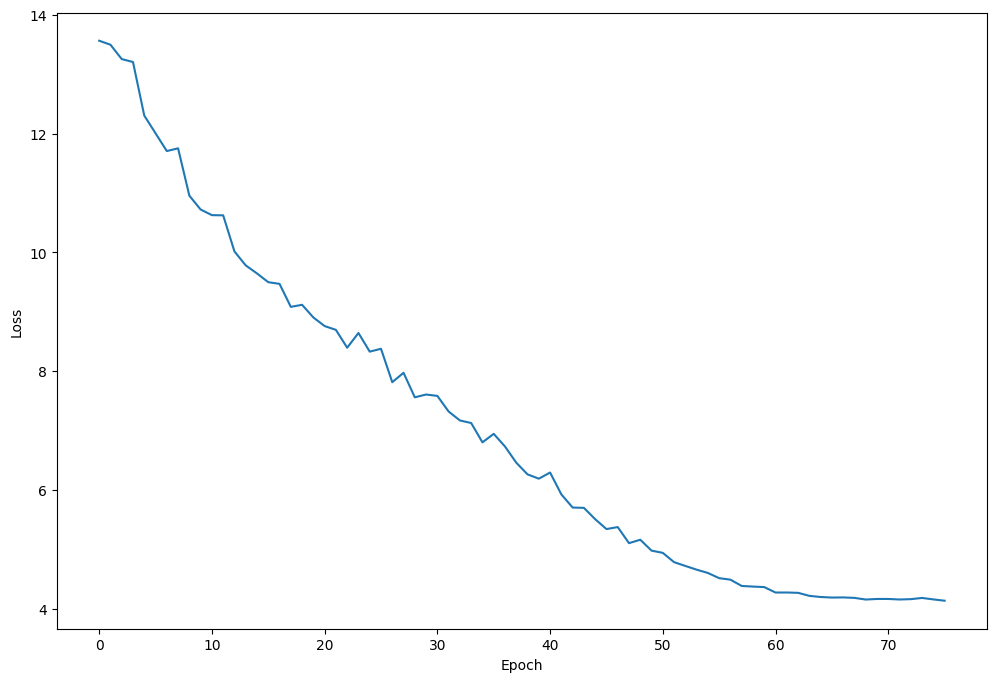

In [45]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

<br>

Let's see the embeddings in the latent space. Note that, the features extracted well separate some classes in the latent space! This would ease the learning process during fine-tuning

28/28 [==============================] - 0s 2ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 873 samples in 0.001s...
[t-SNE] Computed neighbors for 873 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 873 / 873
[t-SNE] Mean sigma: 0.325611
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.786201
[t-SNE] KL divergence after 1000 iterations: 0.431841


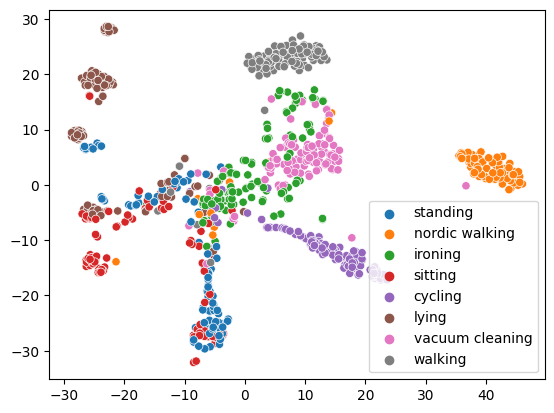

In [46]:
from sklearn.manifold import TSNE
import seaborn as sns

intermediate_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer("global_max_pooling1d").output)

embeddings = intermediate_model.predict(samples[test])

features_reduced = TSNE(perplexity=30, verbose=1, random_state=42).fit_transform(embeddings)

sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=[lab for lab in labels[test]])
plt.show()

<br>

After pre-training, we can fine-tune the Sim-CLR model with our fine-tuning set

In [47]:
def create_full_classification_model_from_base_model(base_model, num_classes=len(classes), last_freeze_layer=4):
    intermediate_x = base_model.get_layer("global_max_pooling1d").output

    x = Dense(1024, activation='relu')(intermediate_x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.inputs, outputs=outputs, name="sim_clr_based_classifier")

    for layer in model.layers:
        layer.trainable = False

    for layer in model.layers[last_freeze_layer+1:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

Creating the model...

Training...
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 2.5123 - accuracy: 0.1500 - val_loss: 1.7799 - val_accuracy: 0.2000
Epoch 2/50
1/1 [==============================] - 0s 35ms/step - loss: 1.5401 - accuracy: 0.3750 - val_loss: 1.9251 - val_accuracy: 0.4000
Epoch 3/50
1/1 [==============================] - 0s 39ms/step - loss: 1.4229 - accuracy: 0.5000 - val_loss: 1.8728 - val_accuracy: 0.6000
Epoch 4/50
1/1 [==============================] - 0s 38ms/step - loss: 1.3610 - accuracy: 0.5000 - val_loss: 1.6500 - val_accuracy: 0.6000
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 1.2262 - accuracy: 0.6500 - val_loss: 1.3238 - val_accuracy: 0.6000
Epoch 6/50
1/1 [==============================] - 0s 41ms/step - loss: 1.0701 - accuracy: 0.6500 - val_loss: 0.9777 - val_accuracy: 0.6000
Epoch 7/50
1/1 [==============================] - 0s 37ms/step - loss: 0.9240 - accuracy: 0.7000 - val_loss: 0.7163 - val_accuracy: 0

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

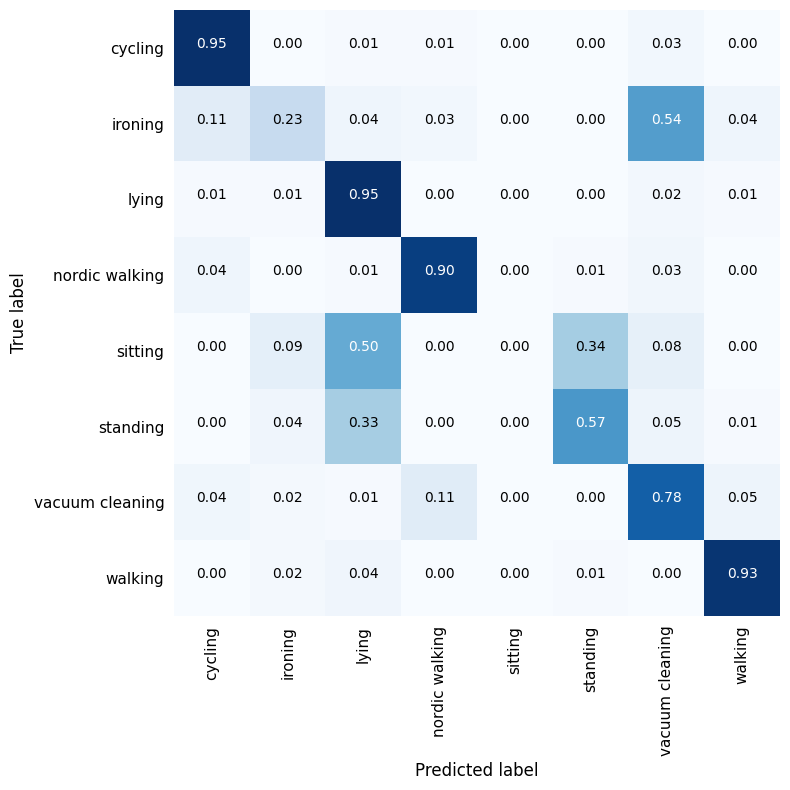

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 50
batch_size = 200

# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("Creating the model...")
full_classifier = create_full_classification_model_from_base_model(trained_simclr_model)


print("\nTraining...")
history = full_classifier.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = full_classifier.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)


Also self-supervised learning allows boosting the recognition rates, in this case, even without using any labeled data during pre-training like transfer learning.

<br>

|                       | Baseline |   | Self-Supervised Learning<br>+<br>Fine-Tuning |  
|-----------------------|:--------:|---|:--------------------------------:|
| Accuracy              |    0.5269     |   |                 **0.6621**                |   
| Macro avg F1-score    |     0.4357    |   |                 **0.6113**                |   
| Weighted avg F1-score |     0.4298    |   |                 **0.6026**                |